In [1]:
!pip install -r requirements.txt
!pip install numpy

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import heapq
import matplotlib.pyplot as plt
from PIL import Image
import os
import rasterio
import time
import cv2

# Load Data

In [3]:
#Input File names
road_mask_path = "South_Clear_Creek\South_Clear_Creek_Roads_Mask.tif"
dem_path = 'South_Clear_Creek\South_Clear_Creek_BareEarth_DEM_1m.tif'
hillshade_path = 'South_Clear_Creek\South_Clear_Creek_BareEarth_Hillshade_1m.tif'

#Output file names
output_dem_path = "masked_dem_output.tif"
rover_visualization_output = "rover_astar_result3_hillshade.png"

<>:2: SyntaxWarning: invalid escape sequence '\S'
<>:3: SyntaxWarning: invalid escape sequence '\S'
<>:4: SyntaxWarning: invalid escape sequence '\S'
<>:2: SyntaxWarning: invalid escape sequence '\S'
<>:3: SyntaxWarning: invalid escape sequence '\S'
<>:4: SyntaxWarning: invalid escape sequence '\S'
C:\Users\quinn\AppData\Local\Temp\ipykernel_48036\882505383.py:2: SyntaxWarning: invalid escape sequence '\S'
  road_mask_path = "South_Clear_Creek\South_Clear_Creek_Roads_Mask.tif"
C:\Users\quinn\AppData\Local\Temp\ipykernel_48036\882505383.py:3: SyntaxWarning: invalid escape sequence '\S'
  dem_path = 'South_Clear_Creek\South_Clear_Creek_BareEarth_DEM_1m.tif'
C:\Users\quinn\AppData\Local\Temp\ipykernel_48036\882505383.py:4: SyntaxWarning: invalid escape sequence '\S'
  hillshade_path = 'South_Clear_Creek\South_Clear_Creek_BareEarth_Hillshade_1m.tif'


In [4]:
start = (3144, 6855)
goal = (5000, 6000)

# Preprocess DEM file

In [5]:
# Function to mask values greater than a certain threshold 
def mask_values_above_threshold(dem_data, threshold_val):
    # Replace values above the threshold with NaN
    dem_data = np.where(dem_data > threshold_val, np.nan, dem_data)
    return dem_data

# Function to load and mask DEM data
def load_and_mask_dem(dem_path, threshold_val):
    with rasterio.open(dem_path) as src:
        # Read the DEM data (first band)
        dem_data = src.read(1)
        
        # Mask values greater than the threshold
        dem_data = mask_values_above_threshold(dem_data, threshold_val)
        
        # Optionally, apply a mask for "no data" values as well (NaN in this case)
        dem_data = np.ma.masked_invalid(dem_data)  # Mask NaN values
        
    return dem_data

In [6]:
threshold_val = 999999

# Load and mask the DEM data and convert to nmpy
masked_dem = load_and_mask_dem(dem_path, threshold_val)
masked_dem = np.array(masked_dem)

# Get the min and max values for the DEM and print
min_value = np.nanmin(masked_dem)
max_value = np.nanmax(masked_dem)
print(f"Minimum value in DEM (ignoring NaNs): {min_value}")
print(f"Maximum value in DEM (ignoring NaNs): {max_value}")

# Calculate and print percentiles
percentiles = [10, 25, 50, 75, 90]
percentile_values = {p: np.nanpercentile(masked_dem, p) for p in percentiles}
print("\nPercentiles of DEM Data:")
for p, value in percentile_values.items():
    print(f"{p}th percentile: {value}")

# Optionally, save the masked DEM to a new file
def save_masked_dem(input_dem_path, output_dem_path, masked_dem):
    # Open the original DEM file to retrieve metadata (like CRS, transform, etc.)
    with rasterio.open(input_dem_path) as src:
        metadata = src.meta
    
    # Update metadata to match the new masked DEM
    metadata.update(dtype=rasterio.float32, count=1)
    
    # Write the masked DEM to a new file
    with rasterio.open(output_dem_path, 'w', **metadata) as dst:
        dst.write(masked_dem.astype(np.float32), 1)  # Write the masked DEM data to band 1
    
    print(f"✅ Masked DEM saved as '{output_dem_path}'")

# Assuming 'masked_dem' is your processed DEM
save_masked_dem(dem_path, output_dem_path, masked_dem)

Minimum value in DEM (ignoring NaNs): 2587.711669921875
Maximum value in DEM (ignoring NaNs): 4210.41943359375

Percentiles of DEM Data:
10th percentile: 3143.8408203125
25th percentile: 3372.56689453125
50th percentile: 3546.607421875
75th percentile: 3716.11181640625
90th percentile: 3855.142822265625
✅ Masked DEM saved as 'masked_dem_output.tif'


# A* model implementation

In [7]:
Image.MAX_IMAGE_PIXELS = None

def load_image_as_array(path, grayscale=True):
    img = Image.open(path)
    arr = np.array(img.convert("L" if grayscale else "RGB"))
    print(arr)
    return arr

    
def rover_cost(current, neighbor, dem, road_mask, road_weight=.5, offroad_weight=2.5, elevation_weight= 5, elevation_resistance = 4, downhill_factor = 0.5, uphill_factor = 1.5):
    elevation_cost = dem[neighbor] - dem[current]
    
    if elevation_cost > 0: 
        elevation_cost = elevation_cost * elevation_weight * uphill_factor

    if elevation_cost < 0:
        elevation_cost = elevation_cost * elevation_weight * downhill_factor

    if road_mask[neighbor] == 1:
        return road_weight + elevation_cost 
    else:
        return offroad_weight + elevation_cost * elevation_resistance

def heuristic(a, b): #Based on Euclidean distance
    return np.linalg.norm(np.array(a) - np.array(b))

def reconstruct_path(came_from, current):
    path = [current]
    while current in came_from:
        current = came_from[current]
        path.append(current)
    return path[::-1]

def astar_rover(start, goal, dem, road_mask):
    rows, cols = dem.shape
    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}
    g_score = {start: 0}
    f_score = {start: heuristic(start, goal)}

    while open_set:
        _, current = heapq.heappop(open_set)

        if current == goal:
            return reconstruct_path(came_from, current), g_score

        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1),
                       (-1, -1), (-1, 1), (1, -1), (1, 1)]:
            nx, ny = current[0] + dx, current[1] + dy
            if 0 <= nx < rows and 0 <= ny < cols:
                neighbor = (nx, ny)
                tentative = g_score[current] + rover_cost(current, neighbor, dem, road_mask)

                if neighbor not in g_score or tentative < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative
                    f_score[neighbor] = tentative + heuristic(neighbor, goal)
                    heapq.heappush(open_set, (f_score[neighbor], neighbor))

    return None, g_score

In [8]:
# if not os.path.exists(road_mask_path) or not os.path.exists(dem_path):
#     raise FileNotFoundError("🚫 DEM or road mask file not found.")

# road_mask = load_image_as_array(road_mask_path)
# dem = masked_dem 

# if road_mask.max() > 1:
#     _, road_mask = cv2.threshold(road_mask, 30, 1, cv2.THRESH_BINARY)

# print("✅ Images loaded.")
# print("Road shape:", road_mask.shape)
# print("DEM shape:", dem.shape)

# print("Start:", start)
# print("Goal:", goal)
# # Set the start time
# start_time = time.time()

# # Run the A* algorithm (you can modify this based on your actual A* function)
# path, g_score = astar_rover(start, goal, dem, road_mask)

# # Set the end time
# end_time = time.time()

# # Calculate the elapsed time
# elapsed_time = end_time - start_time

# print(f"Time taken to run A* algorithm: {elapsed_time:.4f} seconds")
# print("✅Model Done")

In [9]:
def bidir_reconstruct_path(came_from, start, goal, meeting_point):
    path = [meeting_point]
    current = meeting_point
    while current in came_from['start']:
        current = came_from['start'][current]
        path.append(current)
    path = path[::-1]
    
    current = meeting_point
    while current in came_from['goal']:
        current = came_from['goal'][current]
        path.append(current)
    
    return path

def bidirectional_search(start, goal, dem, road_mask):
    rows, cols = dem.shape
    open_set = {
        'start': [(0, start)],
        'goal': [(0, goal)]
    }
    came_from = {
        'start': {},
        'goal': {}
    }
    g_score = {
        'start': {start: 0},
        'goal': {goal: 0}
    }
    f_score = {
        'start': {start: heuristic(start, goal)},
        'goal': {goal: heuristic(goal, start)}
    }
    
    while open_set['start'] and open_set['goal']:
        for direction in ['start', 'goal']:
            _, current = heapq.heappop(open_set[direction])

            if current in g_score['start'] and current in g_score['goal']:
                return bidir_reconstruct_path(came_from, start, goal, current), g_score
            
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1),
                           (-1, -1), (-1, 1), (1, -1), (1, 1)]:
                nx, ny = current[0] + dx, current[1] + dy
                if 0 <= nx < rows and 0 <= ny < cols:
                    neighbor = (nx, ny)
                    tentative = g_score[direction][current] + rover_cost(current, neighbor, dem, road_mask)

                    if neighbor not in g_score[direction] or tentative < g_score[direction][neighbor]:
                        came_from[direction][neighbor] = current
                        g_score[direction][neighbor] = tentative
                        f_score[direction][neighbor] = tentative + heuristic(neighbor, goal if direction == 'start' else start)
                        heapq.heappush(open_set[direction], (f_score[direction][neighbor], neighbor))

    return None, g_score


In [10]:
if not os.path.exists(road_mask_path) or not os.path.exists(dem_path):
    raise FileNotFoundError("🚫 DEM or road mask file not found.")

road_mask = load_image_as_array(road_mask_path)
dem = masked_dem  # Removed the normalization

if road_mask.max() > 1:
    _, road_mask = cv2.threshold(road_mask, 30, 1, cv2.THRESH_BINARY)

print("✅ Images loaded.")
print("Road shape:", road_mask.shape)
print("DEM shape:", dem.shape)

print("Start:", start)
print("Goal:", goal)

# Set the start time
start_time = time.time()

# Run the A* algorithm (you can modify this based on your actual A* function)
path, g_score = bidirectional_search(start, goal, dem, road_mask)

# Set the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print(f"Time taken to run A* algorithm: {elapsed_time:.4f} seconds")

print("Model Done")

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
✅ Images loaded.
Road shape: (13115, 10460)
DEM shape: (13115, 10460)
Start: (3144, 6855)
Goal: (5000, 6000)
Time taken to run A* algorithm: 544.4204 seconds
Model Done


# Output file generation and visualization

In [11]:
def visualize_path(road_mask, path, start, goal, output_path):
    road_rgb = np.zeros((road_mask.shape[0], road_mask.shape[1], 3), dtype=np.uint8)
    road_rgb[road_mask == 1] = [255, 255, 255]  # white roads

    for x, y in path:
        road_rgb[x, y] = [255, 0, 0]  # red path

    sx, sy = start
    cv2.circle(road_rgb, (sy, sx), 4, (0, 255, 0), thickness=-1)  # green start

    gx, gy = goal
    radius = 3
    for dx in range(-radius, radius + 1):
        for dy in range(-radius, radius + 1):
            nx, ny = gx + dx, gy + dy
            if 0 <= nx < road_rgb.shape[0] and 0 <= ny < road_rgb.shape[1]:
                if np.random.rand() < 0.5:
                    road_rgb[nx, ny] = [0, 0, 255]  # blue goal scatter

    cv2.imwrite(output_path, road_rgb)
    print(f"✅ Final result saved as: {output_path}")

def visualize_path_on_hillshade(hillshade_path, path, start, goal, output_path, line_thickness=3):
    # Load the hillshade image as the background (assume it's a grayscale image)

    hillshade = Image.open(hillshade_path).convert("L")  # Convert to 8-bit grayscale
    hillshade.save("converted_hillshade.png")  # Save as PNG
    hillshade = cv2.imread("converted_hillshade.png", cv2.IMREAD_GRAYSCALE)

    hillshade_rgb = cv2.cvtColor(hillshade, cv2.COLOR_GRAY2BGR)

    # Draw the path on the hillshade (handle float32 by rounding)
    for i in range(1, len(path)):
        start_point = tuple(np.round(path[i - 1]).astype(int))  # Convert float32 to int
        end_point = tuple(np.round(path[i]).astype(int))
        cv2.line(hillshade_rgb, start_point[::-1], end_point[::-1], (255, 0, 0), thickness=line_thickness)  # Blue path

    # Draw the start and goal points (round float32 values)
    sx, sy = np.round(start).astype(int)
    gx, gy = np.round(goal).astype(int)
    
    cv2.circle(hillshade_rgb, (sy, sx), 6, (0, 255, 0), thickness=-1)  # Green start
    cv2.circle(hillshade_rgb, (gy, gx), 6, (0, 0, 255), thickness=-1)  # Red goal

    # Save the output image
    cv2.imwrite(output_path, hillshade_rgb)
    print(f"✅ Final result saved as: {output_path}")

In [12]:
if path:
    visualize_path_on_hillshade(hillshade_path, path, start, goal, rover_visualization_output)
else:
    print("❌ No path found.")

✅ Final result saved as: rover_astar_result3_hillshade.png


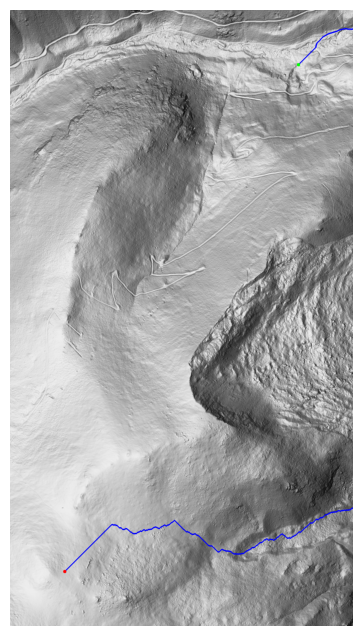

In [13]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Set the margin around the start and goal points
margin = 200

# Load the image (make sure to replace with your actual file path)
image_path = "rover_astar_result3_hillshade.png"
image = cv2.imread(image_path)

# Ensure the image was loaded properly
if image is None:
    print("Error: Could not load image.")
else:
    # Convert the image from BGR to RGB for proper display with matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Calculate the bounding box for the crop area based on the start and goal points, including the margin
    x_start = max(min(start[1], goal[1]) - margin, 0)  # Make sure x_start is not less than 0
    x_end = min(max(start[1], goal[1]) + margin, image_rgb.shape[1])  # Limit x_end to the image width
    y_start = max(min(start[0], goal[0]) - margin, 0)  # Make sure y_start is not less than 0
    y_end = min(max(start[0], goal[0]) + margin, image_rgb.shape[0])  # Limit y_end to the image height

    # Ensure the crop dimensions are valid (non-zero area)
    if x_start >= x_end or y_start >= y_end:
        print("Error: Invalid crop region, the calculated bounding box is empty.")
    else:
        # Crop the image based on the bounding box calculated
        cropped_image = image_rgb[y_start:y_end, x_start:x_end]

        # Display the cropped image
        plt.figure(figsize=(10, 8))
        plt.imshow(cropped_image)
        plt.axis('off')  # Turn off axis
        plt.show()